In [1]:
import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset, Dataset, WeightedRandomSampler
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from typing import Tuple, Callable


from utils import N_Layer_Dense_Classifier, samples_per_class, fit, plot_train_val

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
batch_size = 256
learning_rate = 0.001
epochs = 40
num_classes = 10
input_dim = 512
hidden_dim = 256
latent_dim = 2

In [3]:
class CEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        super(CEncoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(input_dim + n_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim), # 2 for mean and variance.
        )
        
        self.norm = torch.distributions.Normal(0, 1)
        self.norm.loc = self.norm.loc.cuda() # hack to get sampling on the GPU
        self.norm.scale = self.norm.scale.cuda()
        self.kl = 0
        

    def forward(self, x, y):
        x = self.encode(torch.cat((x,y), dim=-1))
        mean, log_var = torch.chunk(x, 2, dim=-1)
        sigma = torch.exp(log_var)
        z = mean + sigma * self.norm.sample(mean.shape)
        self.kl = (sigma**2 + mean**2 - log_var - 0.5).mean() #TODO: check if mean really correct reduction here
        return z
    
class CDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, n_classes):
        super(CDecoder, self).__init__()
        
        self.decode = nn.Sequential(
            nn.Linear(latent_dim + n_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim), 
            nn.Sigmoid()
        )
        
    def forward(self, x, y):
        return self.decode(torch.cat((x,y), dim=-1))
    
    
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        super(CVAE, self).__init__()
        
        self.encoder = CEncoder(input_dim, hidden_dim, latent_dim, n_classes)
        self.decoder = CDecoder(latent_dim, hidden_dim, input_dim, n_classes)
        self.n_classes = n_classes
        
    def forward(self, x, y):
        z = self.encoder(x, y)
        return self.decoder(z, y)


def cvae_fit(model, dl, opt, epochs=20, device="cuda", beta=1):
    model.to(device)
    
    train_loss_epoch = []
    
    for epoch in range(epochs):
        for x, y in tqdm(dl, desc=f'Epoch {epoch + 1}'):
            x = x.to(device)
            y_oh = F.one_hot(y, num_classes=model.n_classes).to(device)
            preds = model(x, y_oh)
            # rec_loss = ((x - preds)**2).sum()
            rec_loss = beta * F.binary_cross_entropy(preds, x, reduction='none').sum(-1).mean()            
            loss = rec_loss + model.encoder.kl
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        train_loss_epoch.append(loss)
    
    return train_loss_epoch

In [4]:
data_path = 'data/cifar10_imbalanced_0.01' 
train_path= os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

train_feats = torch.load(os.path.join(train_path, 'image_features.pt'))
train_labels = torch.load(os.path.join(train_path, 'labels.pt'))

test_feats = torch.load(os.path.join(test_path, 'image_features.pt'))
test_labels = torch.load(os.path.join(test_path, 'labels.pt'))

def normalize(tensor):
    '''
    Normalize features of tensor of shape (samples, features).
    '''
    _min = tensor.min(dim=0).values
    _max = tensor.max(dim=0).values
    
    return (tensor - _min) / (_max - _min), _min, _max

train_feats_norm, train_min, train_max = normalize(train_feats)
test_feats_norm, test_min, test_max = normalize(test_feats)

train_ds = TensorDataset(train_feats_norm, train_labels)
test_ds = TensorDataset(test_feats_norm, test_labels)

print(len(train_ds), len(test_ds))

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2, shuffle=False)

12406 10000


In [5]:
cvae = CVAE(input_dim, hidden_dim, latent_dim, num_classes)
cvae

CVAE(
  (encoder): CEncoder(
    (encode): Sequential(
      (0): Linear(in_features=522, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=4, bias=True)
    )
  )
  (decoder): CDecoder(
    (decode): Sequential(
      (0): Linear(in_features=12, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): Sigmoid()
    )
  )
)

In [6]:
opt = torch.optim.Adam(cvae.parameters(), lr=learning_rate)
hist = cvae_fit(cvae, train_dl, opt, device=device, beta=0.1, epochs=epochs) # beta < 1 -> less focus on reconstruction loss


Epoch 40: 100%|██████████| 49/49 [00:00<00:00, 222.87it/s]


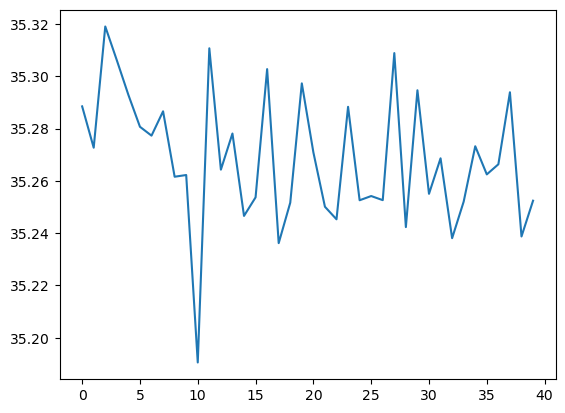

In [7]:
plt.plot(range(epochs), [l.item() for l in hist])

In [8]:
def plot_latent(autoencoder, dl, cls, num_batches=10):
    for i, (x, y) in enumerate(dl):
        z = autoencoder.encoder(x.to(device), F.one_hot(y, num_classes=10).to(device))
        z = z.to('cpu').detach().numpy()
        z = z[y == cls]
        plt.scatter(z[:, 0], z[:, 1], c='b')
        # plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            # plt.colorbar()
            break
        
        
@widgets.interact(cls=(0,9))
def plot(cls):
    plot_latent(cvae, train_dl, cls)

interactive(children=(IntSlider(value=4, description='cls', max=9), Output()), _dom_classes=('widget-interact'…

## zero-shot model predictions of reconstructions

In [9]:
# make zero-shot model
zs_weights = torch.load(os.path.join(train_path, "zero_shot_weights.pt"))

def make_zs_model(zs_weights, num_classes):
    zs_model = N_Layer_Dense_Classifier(512, num_classes, 1)

    with torch.no_grad():
        zs_model.model[0].weight.copy_(zs_weights)
        zs_model.model[0].bias.copy_(torch.zeros(num_classes, dtype=zs_weights.dtype))
        
    return zs_model

zs_model = make_zs_model(zs_weights, 10)

def predict_zs(input):
    zs_model.eval()
    zs_model.to(device)
    with torch.no_grad():
        return F.softmax(zs_model(input), dim=0)
    

# plotting function
cifar10_classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
def plot_pred(pred):
    fig, ax = plt.subplots()
    ax.bar(range(10), pred)
    ax.set_xticks(range(10))
    ax.set_xticklabels(cifar10_classes, rotation=45)
    ax.set_ylim(0, 1)
    ax.bar(pred.argmax(), pred.max(), color='r')
    return fig

# reverse normalization 
def un_normalize(tensor, _min, _max):
    return (tensor.to(device) * (_max.to(device) - _min.to(device))) + _min.to(device)

In [10]:
def from_ds(label):
    '''
    Get a random embedding from the training set for the given label.
    '''
    cls_feats = train_feats[train_labels == label]
    ind = torch.randperm(cls_feats.shape[0])[0]
    return cls_feats[ind].to(device)

def recreated(label, seed=None):
    '''
    Get a random embedding from the training set for the given label and reconstruct it using the CVAE.
    '''
    if seed is not None:
        torch.manual_seed(seed)
    cls_feats = train_feats[train_labels == label]
    ind = torch.randint(cls_feats.shape[0], size=(1,)).item()
    print(ind)
    x = cls_feats[ind].to(device)
    y_oh = F.one_hot(torch.tensor(label), num_classes=num_classes).to(device)
    cvae.eval()
    print(cvae(x, y_oh).shape)
    x_hat = un_normalize(cvae(x, y_oh), train_min, train_max)
    return x_hat

def from_latent(latent_1, latent_2, label):
    '''
    Construct an embedding from the given latent variables and label.
    '''
    cvae.eval()
    z = torch.Tensor([latent_1, latent_2]).to(device)
    x_hat = cvae.decoder(z, F.one_hot(torch.tensor(label), num_classes=num_classes).to(device))
    return un_normalize(x_hat, train_min, train_max)

In [11]:
# plot CLIP zero-shot predictions of random elements of each class (execute again to get new samples)
@widgets.interact(cls=(0,9))
def plot(cls):
    pred = predict_zs(from_ds(cls)).to('cpu').squeeze()
    plot_pred(pred)

interactive(children=(IntSlider(value=4, description='cls', max=9), Output()), _dom_classes=('widget-interact'…

In [12]:
# plot CLIP zero-shot predictions of reconstructed embeddings
@widgets.interact(cls=(0,9))
def plot(cls):
    pred = predict_zs(recreated(cls)).to('cpu').squeeze()
    plot_pred(pred)

interactive(children=(IntSlider(value=4, description='cls', max=9), Output()), _dom_classes=('widget-interact'…

In [13]:
# plot CLIP zero-shot predictions of embeddings generated from latent variables
@widgets.interact(dim1=(-10.,10.), dim2=(-10.,10.), cls=(0,9))
def plot(dim1, dim2, cls):
    pred = predict_zs(from_latent(dim1,dim2,cls)).to('cpu').squeeze()
    plot_pred(pred)

interactive(children=(FloatSlider(value=0.0, description='dim1', max=10.0, min=-10.0), FloatSlider(value=0.0, …

# train classifier on reconstructions

In [14]:
cl_batch_size = 256
cl_learning_rate = 0.01
cl_num_feats = 512
cl_num_classes = 10
cl_epochs = 20

In [15]:
spc = samples_per_class(train_labels)
weights = torch.Tensor(1/spc)
probs = (weights - weights.min())/weights.max() # scaling might not be ideal
trans_probs = torch.Tensor([probs[i] for i in train_labels]) 

## Prepare data

In [16]:
cl_train_ds = TensorDataset(train_feats, train_labels)
cl_test_ds = TensorDataset(test_feats, test_labels)

###### baseline ######
sample_weights = [1/spc[i] for i in train_labels]
baseline_train_dl = DataLoader(cl_train_ds, 
                               batch_size=cl_batch_size, 
                               sampler=WeightedRandomSampler( # class balanced sampling
                                   weights=sample_weights, 
                                   num_samples=len(cl_train_ds), 
                                   replacement=True)
                               )

baseline_train_dl_rs = DataLoader(cl_train_ds, batch_size=cl_batch_size, shuffle=True) # random sampling (no rebalancing)
baseline_test_dl = DataLoader(cl_test_ds, batch_size=cl_batch_size * 2, shuffle=False)

###### only latent ######
## generate dataset with only with decoder (no original training samples used) (try different sizes)
cvae.eval()
n_per_class = 5000
gen_train_feats = torch.zeros((n_per_class * num_classes, 512))
gen_train_labels = torch.zeros((n_per_class * num_classes)).to(int)

for cls in range(num_classes):
    latents = torch.randn((n_per_class, latent_dim)).to(device) # sample from standard normal distribution in latent space of cvae
    x_hat = cvae.decoder(latents, F.one_hot(torch.full((n_per_class,),cls), num_classes=num_classes).to(device))
    x_hat = un_normalize(x_hat, train_min, train_max)
    gen_train_feats[cls*n_per_class : (cls+1)*n_per_class] = x_hat.detach()
    gen_train_labels[cls*n_per_class : (cls+1)*n_per_class] = torch.full((n_per_class,), cls)

print(f"{gen_train_feats.shape=}")
print(f"{gen_train_labels.shape=}")


gen_train_dl = DataLoader( 
    TensorDataset(gen_train_feats.to(device),gen_train_labels.to(device)), 
    batch_size=cl_batch_size, shuffle=True)  # using random sampling because dataset is balanced


###### add generated samples to imbalance dataset ######
class TensorDatasetTransform(Dataset[Tuple[Tensor, Tensor]]):
    r"""Dataset wrapping tensors and optionally transforming samples.
    
    Each sample will be retrieved by indexing tensors along the first dimension.

    Args:
        tensors (Tuple): two tensors (features, labels) that have the same size of the first dimension.
        tranform (Callable | None): function that transforms each sample of first tensor.
        transform_probs (Tensor): probabilities of transformation for all samples.
    """

    def __init__(self, tensors: Tuple[Tensor, Tensor], 
                 transform: Callable[[Tensor, Tensor], Tensor] | None = None,
                 transform_probs: Tensor | None = None) -> None:
        
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors), "Size mismatch between tensors"
        self.tensors = tensors
        self.transform = transform
        self.trans_probs = transform_probs
        
        if self.transform:
            assert self.trans_probs is not None, "Transform_probs not provided, although transform was provided."
        
    def __getitem__(self, index):
        feat, label = self.tensors[0][index], self.tensors[1][index]
        if self.transform:
            if torch.bernoulli(self.trans_probs[index]):
                feat = self.transform(feat, label)
        return feat, label

    def __len__(self):
        return self.tensors[0].size(0)

# function to generate with cvae
def transform(feat: Tensor, label: Tensor): # currently not using feat, but simply sampling from random normal dist. Could additionally include augmentation of latent CVAE representation of feat, but need to make sure that distribution is approximately normal
    latents = torch.randn((latent_dim)).to(device)
    y_oh = F.one_hot(label, num_classes=num_classes).to(device)
    x_hat = cvae.decoder(latents, y_oh)
    return un_normalize(x_hat, train_min, train_max)


mixed_train_ds = TensorDatasetTransform( # dataset applies transformation (generating sample from CVAE latent space) according to probability trans_probs, which is higher for classes with fewer samples
    (train_feats.to(device), train_labels.to(device)), 
    transform, 
    trans_probs)

mixed_train_dl = DataLoader( # class balanced sampling
    mixed_train_ds, 
    batch_size=batch_size, 
    sampler=WeightedRandomSampler(weights=sample_weights, num_samples=len(mixed_train_ds), replacement=True))

gen_train_feats.shape=torch.Size([50000, 512])
gen_train_labels.shape=torch.Size([50000])


## baseline rs

N_Layer_Dense_Classifier(
  (model): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)


Epoch 20 testing: 100%|██████████| 20/20 [00:00<00:00, 261.02it/s]


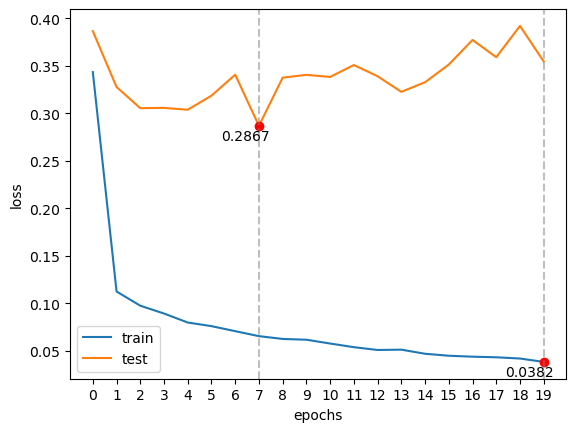

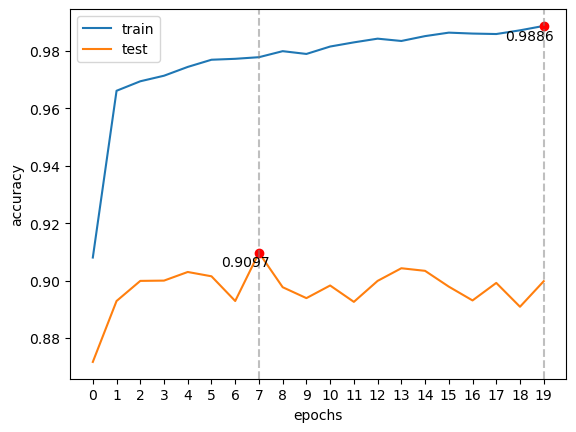

In [17]:
model = N_Layer_Dense_Classifier(cl_num_feats, cl_num_classes, num_layers=1)
print(model)

loss_fn = F.cross_entropy
optim = torch.optim.Adam(model.parameters(), lr=cl_learning_rate)
         
loss_train, acc_train, loss_test, acc_test = fit(cl_epochs, 
                                                 model, 
                                                 loss_fn, 
                                                 optim, 
                                                 baseline_train_dl_rs, # random sampling baseline
                                                 baseline_test_dl, 
                                                 device)

plot_train_val(loss_train, loss_test, 'loss', extrema_fn=min)
plot_train_val(acc_train, acc_test, 'accuracy', extrema_fn=max)
plt.show()

## baseline cbs

N_Layer_Dense_Classifier(
  (model): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)


Epoch 20 testing: 100%|██████████| 20/20 [00:00<00:00, 256.65it/s]


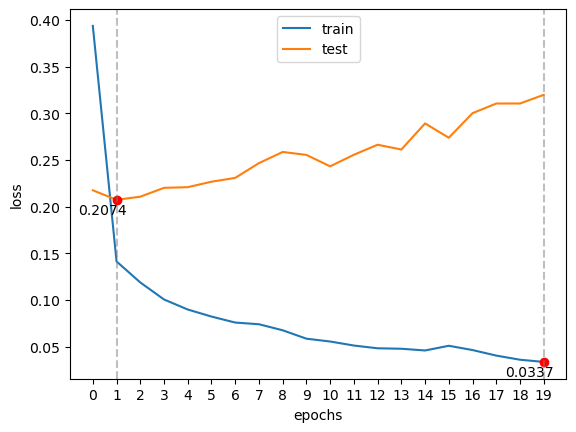

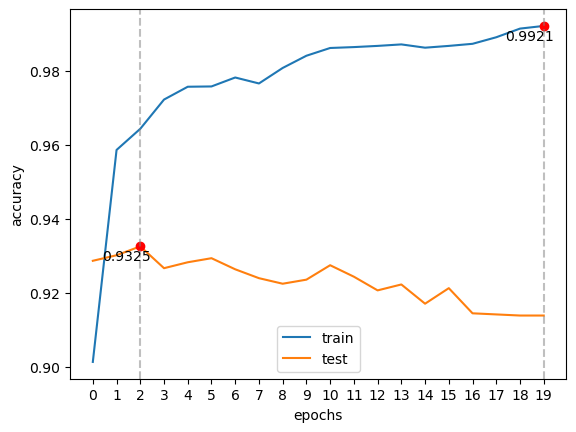

In [18]:
model = N_Layer_Dense_Classifier(cl_num_feats, cl_num_classes, num_layers=1)
print(model)

loss_fn = F.cross_entropy
optim = torch.optim.Adam(model.parameters(), lr=cl_learning_rate)
         
loss_train, acc_train, loss_test, acc_test = fit(cl_epochs, 
                                                 model, 
                                                 loss_fn, 
                                                 optim, 
                                                 baseline_train_dl, # baseline class balanced sampling
                                                 baseline_test_dl, 
                                                 device)

plot_train_val(loss_train, loss_test, 'loss', extrema_fn=min)
plot_train_val(acc_train, acc_test, 'accuracy', extrema_fn=max)
plt.show()

## only from latent

the train loss is almost immediately zero and accuracy 100%. Generated samples might not have enough diversity. Could try sampling with higher standard deviation.

N_Layer_Dense_Classifier(
  (model): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)


Epoch 20 testing: 100%|██████████| 20/20 [00:00<00:00, 286.30it/s]


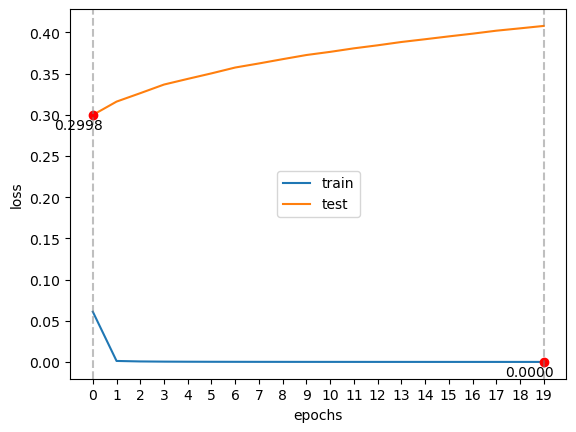

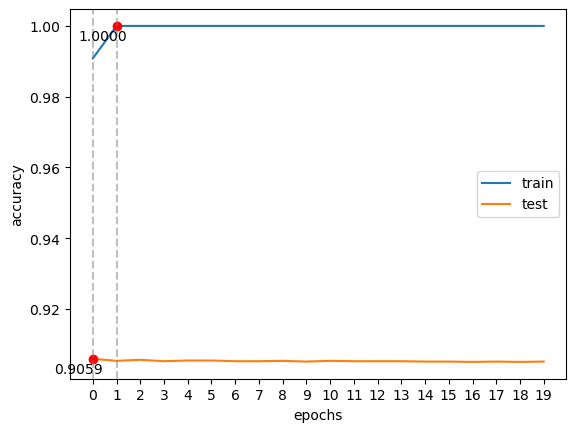

In [19]:
model = N_Layer_Dense_Classifier(cl_num_feats, cl_num_classes, num_layers=1)
print(model)

loss_fn = F.cross_entropy
optim = torch.optim.Adam(model.parameters(), lr=cl_learning_rate)
         
loss_train, acc_train, loss_test, acc_test = fit(cl_epochs, 
                                                 model, 
                                                 loss_fn, 
                                                 optim, 
                                                 gen_train_dl, # only using samples generated from CVAE latent space
                                                 baseline_test_dl, 
                                                 device)

plot_train_val(loss_train, loss_test, 'loss', extrema_fn=min)
plot_train_val(acc_train, acc_test, 'accuracy', extrema_fn=max)
plt.show()

# original + generated
currently a bit worse than simple class-balanced sampling:
* generated samples might not have high diversity (see above cell) and are generated according to standard normal distribution
* the CVAE is trained to represent the training samples as a std. norm. dist. in its latent space. But this is not necessarily the training examples of a single class (especially very small classes)
* the training set is highly imbalanced. For some classes, the generated samples far outweigh the number of original samples. This could be a problem. It would be good to try different imbalance ratios, plot per-class-accuracy, and sample from points close to original samples in cvae latent space (not from a std-norm-dist)
* latent space only has 2 dimensions (used for visualization and testing purposes). More might be better
* not much focus on reconstruction loss relative to KL-divergence. Maybe better reconstruction loss gives better results
* cvae training not optimized. E.g. include plots for test loss, also maybe plots for separate parts of the loss function, check that samples are normally distributed in each dimension of latent space 

N_Layer_Dense_Classifier(
  (model): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)


Epoch 20 testing: 100%|██████████| 20/20 [00:00<00:00, 99.89it/s]


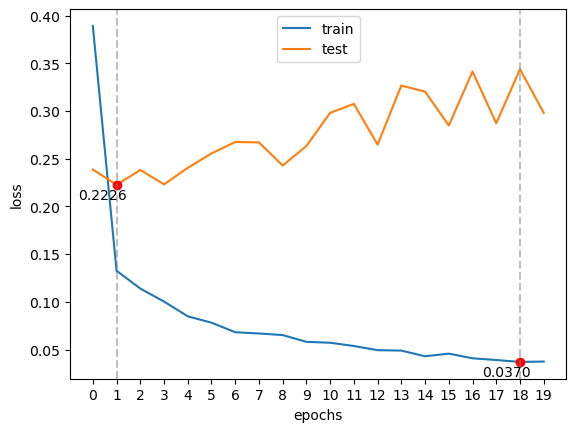

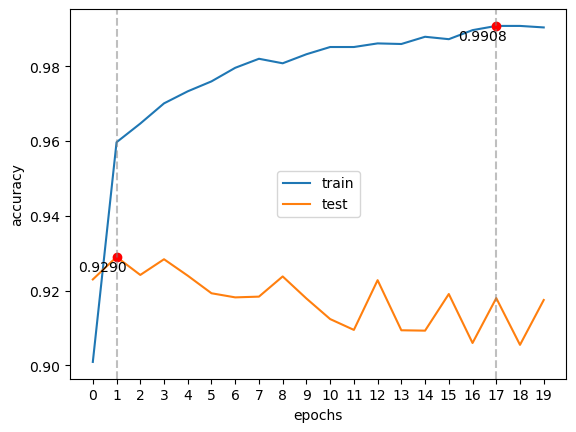

In [20]:
model = N_Layer_Dense_Classifier(cl_num_feats, cl_num_classes, num_layers=1)
print(model)

loss_fn = F.cross_entropy
optim = torch.optim.Adam(model.parameters(), lr=cl_learning_rate)
         
loss_train, acc_train, loss_test, acc_test = fit(cl_epochs, 
                                                 model, 
                                                 loss_fn, 
                                                 optim, 
                                                 mixed_train_dl, # generate samples for classes with few samples        
                                                 baseline_test_dl, 
                                                 device)

plot_train_val(loss_train, loss_test, 'loss', extrema_fn=min)
plot_train_val(acc_train, acc_test, 'accuracy', extrema_fn=max)
plt.show()